In this project, we will use an RNN architecture to build a Machine Translation model.

It will use as a corpus wikipedia dumps.

Either the source or the target will be English. We will, in our case, try English to French Translation.

In [ ]:
#imports
!pip3 install numpy
!pip3 install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cu117
#or any nightly version so long as pytorch > 1.11 https://pytorch.org/
!pip3 install gensim transformers d2l==1.0.0a1.post0

#In pytorch functional.py, change PILLOW_VERSION to __version__
#there are two places to change

Dataset

In [1]:
#Test samples location and preprocessing

#cell almost entirely from https://d2l.ai/chapter_recurrent-modern/machine-translation-and-dataset.html
import os
import torch
from d2l import torch as d2l

class MTFraEng(d2l.DataModule):  #@save
    def _download(self):
        d2l.extract(d2l.download(
            d2l.DATA_URL+'fra-eng.zip', self.root,
            '94646ad1522d915e7b0f9296181140edcf86a4f5'))
        with open(self.root + '/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

@d2l.add_to_class(MTFraEng)  #@save
def _preprocess(self, text):
    # Replace non-breaking space with space
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    # Insert space between words and punctuation marks
    no_space = lambda char, prev_char: char not in 'aàâbcdeéèêâfghiîjklmnoôpqrstuûvwxyz ' and prev_char != ' '
    out = [' ' + char if i > 0 and no_space(char, text[i - 1]) else char
           for i, char in enumerate(text.lower())]
    
    #insert space after punctuation marks
    no_space = lambda char, next_char: char not in 'aàâbcdeéèêâfghiîjklmnoôpqrstuûvwxyz ' and next_char != ' '
    out = [char + ' ' if i < len(text) - 1 and no_space(char, text[i + 1]) else char
              for i, char in enumerate(out)]
    return ''.join(out)

@d2l.add_to_class(MTFraEng)  #@save
def _tokenize(self, text, max_examples=None):
    src, tgt = [], []
    for i, line in enumerate(text.split('\n')):
        if max_examples and i > max_examples: break
        parts = line.split('\t')
        if len(parts) == 2:
            # Skip empty tokens
            src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])  # src.append(EOS_token) ? 
            tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
    return src, tgt

@d2l.add_to_class(MTFraEng)  #@save
def __init__(self, batch_size=10, num_steps=15, num_train=162000):  #15, 162000
    super(MTFraEng, self).__init__()
    self.save_hyperparameters()
    self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
        self._download())


@d2l.add_to_class(MTFraEng)  #@save
def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
    def _build_array(sentences, vocab, is_tgt=False):
        pad_or_trim = lambda seq, t: (
            seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
        sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
        if is_tgt:
            sentences = [['<bos>'] + s for s in sentences]
        if vocab is None:
            vocab = d2l.Vocab(sentences, min_freq=3)
        array = torch.tensor([vocab[s] for s in sentences])
        valid_len = (array != vocab['<pad>']).type(torch.int64).sum(1)
        return array, vocab, valid_len
    src, tgt = self._tokenize(self._preprocess(raw_text),
                              self.num_train)
    
    src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
    tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)

    
    return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
            src_vocab, tgt_vocab)

@d2l.add_to_class(MTFraEng)  #@save
def build(self, src_sentences, tgt_sentences):
    raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
        src_sentences, tgt_sentences)])
    arrays, _, _ = self._build_arrays(
        raw_text, self.src_vocab, self.tgt_vocab)
    return arrays

#src, tgt, _,  _ = data.build(['hi .'], ['salut .'])
#print('source:', data.src_vocab.to_tokens(src[0].type(torch.int64)))
#print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int64)))

@d2l.add_to_class(MTFraEng)  #@save
def get_dataloader(self, train, seed=0, maxi=158140):
    if (maxi > self.num_train):
        raise ValueError("maxi must be less than the length of the dataset")
    
    for array in self.arrays:
        array = array[0:maxi]
        
    self.num_train = maxi
    self.num_test = int(maxi * 0.3)
    
    idx = torch.randperm(generator=torch.Generator().manual_seed(seed), n=maxi)
    
    #0 is train, 1 is test, 2 is valid
    if (train == 1):
        idx = idx[int(maxi * 0.8):]
    if (train == 2):
        idx = idx[int(maxi * 0.6):int(maxi * 0.8)]
    else :
        idx = idx[:int(maxi * 0.6)]
    return self.get_tensorloader(self.arrays, train, idx)
    

In [2]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

In [3]:

data = MTFraEng()

In [4]:
print(len(data.get_dataloader(train=1)))
print(len(data.get_dataloader(train=2)))
print(len(data.get_dataloader(train=0)))

3163
3163
9489


Word embedding

# We will use three different types of word embeddings:
# 1. Word2Vec
# 2. GloVe
# 3. FastText


In [5]:
"""## Word2Vec"""
import gensim

In [6]:
#keep in mind you have to launch the notebook inside the git folder to make this work (second one)
from inspect import getsourcefile
import sys
print(os.path.dirname(getsourcefile(lambda:0)))
print(sys.path[0])
print(os.path.abspath(sys.argv[0]))

C:\Users\gille\AppData\Local\Temp\ipykernel_9936
c:\Users\gille\OneDrive\Desktop\web\webtextanalysis
c:\Users\gille\miniconda3\envs\thesis\lib\site-packages\ipykernel_launcher.py


In [7]:
src, tgt, src_valid_len, label = next(iter(data.get_dataloader(train=0)))
print('source:', src[0].type(torch.int64))
print('decoder input:', tgt[0].type(torch.int64))

source: tensor([3204, 6488, 7228,    4, 1608,  568, 4353,    7,   20,   21,   21,   21,
          21,   21,   21])
decoder input: tensor([   20,  5387,  7071,  7987, 10190,  9145,  7331, 10457,     7,    21,
           22,    22,    22,    22,    22])


In [8]:
import numpy as np

def save_split():
    data = MTFraEng(batch_size=5)
    with open("samples/source.txt", "w") as f:
        for i in range(0, data.num_train):
            for word in data.arrays[0][i].numpy() :
                f.write(str(word) + " ")
            f.write("\n")
            
    with open("samples/target.txt", "w") as f:
        for i in range(0, data.num_train):
            for word in data.arrays[1][i].numpy() :
                f.write(str(word) + " ")
            f.write("\n")
            
def load_source():
    return np.loadtxt("samples/source.txt", dtype=str)

def load_target():
    return np.loadtxt("samples/target.txt", dtype=str)

def word_to_token(word, src=True):
    if src :
        return data.src_vocab[word]
    else :
        return data.tgt_vocab[word]

def token_to_word(token, src=True):
    if src :
        return data.src_vocab.to_tokens(token)
    else :
        return data.tgt_vocab.to_tokens(token)

def test_similarity(model, word1, word2, model_name, src=True):
    print("Cosine similarity between '" + word1 + "' and '"+ word2 +"' - " + model_name + " : " + str(model.similarity(word_to_token(word1, src), word_to_token(word2, src))))


In [9]:
#print a few samples
for i in range(2500,2505):
    print(token_to_word(data.arrays[0][i].numpy(), True))

for i in range(2500,2505):
    print(token_to_word(data.arrays[1][i].numpy(), False))

['i', "'", 'm', 'working', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['i', "'", 'm', 'worried', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['i', "'", 've', 'failed', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['ignore', 'them', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['ignore', 'them', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'je', 'suis', 'en', 'train', 'de', 'travailler', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'je', 'me', 'fais', 'du', 'souci', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
['<bos>', 'j', "'", 'ai', 'échoué', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']

In [10]:
if not os.path.exists(sys.path[0] + "/samples/source.txt") or not os.path.exists(sys.path[0] + "/samples/target.txt"):
    save_split()

In [11]:

source_text = load_source()
one_line_source = source_text.reshape([np.prod(source_text.shape)])

#format to be accepted by Word2Vec
one_line_source = [str(i).split() for i in one_line_source]

print(one_line_source[:4])
#print in words 
print([token_to_word(int(i[0]), src=True) for i in one_line_source[:4]])



target_text = load_target()
one_line_target = target_text.reshape([np.prod(target_text.shape)])

#format to be accepted by Word2Vec
one_line_target = [str(i).split() for i in one_line_target]

print(one_line_target[:4])
#print in words 
print([token_to_word(int(i[0]), src=False) for i in one_line_target[:4]])

[['2806'], ['7'], ['20'], ['21']]
['go', '.', '<eos>', '<pad>']
[['20'], ['10312'], ['0'], ['21']]
['<bos>', 'va', '!', '<eos>']


In [12]:
"""## Word2Vec"""
if not os.path.exists(sys.path[0] + "/models/source_w2v_cbow.txt"):
    # Create CBOW model
    source_w2v_model_cbow = gensim.models.Word2Vec(one_line_source, min_count = 1,
                                vector_size = 100, window = 5).wv

if not os.path.exists(sys.path[0] + "/models/source_w2v_skip.txt"):
    # Create Skip Gram model
    source_w2v_model_skip = gensim.models.Word2Vec(one_line_source, min_count = 1, vector_size = 100,
                                                window = 5, sg = 1).wv
    
if not os.path.exists(sys.path[0] + "/models/target_w2v_cbow.txt"):
    # Create CBOW model
    target_w2v_model_cbow = gensim.models.Word2Vec(one_line_target, min_count = 1,
                                vector_size = 100, window = 5).wv

if not os.path.exists(sys.path[0] + "/models/target_w2v_skip.txt"):
    # Create Skip Gram model
    target_w2v_model_skip = gensim.models.Word2Vec(one_line_target, min_count = 1, vector_size = 100,
                                                window = 5, sg = 1).wv

In [13]:
#save the models
if not os.path.exists(sys.path[0] + "/models/source_w2v_cbow.txt"):
    source_w2v_model_cbow.save_word2vec_format(sys.path[0] + "/models/source_w2v_cbow.txt", binary=False)
    
if not os.path.exists(sys.path[0] + "/models/source_w2v_skip.txt"):
    source_w2v_model_skip.save_word2vec_format(sys.path[0] + "/models/source_w2v_skip.txt", binary=False)
    
if not os.path.exists(sys.path[0] + "/models/target_w2v_cbow.txt"):
    target_w2v_model_cbow.save_word2vec_format(sys.path[0] + "/models/target_w2v_cbow.txt", binary=False)

if not os.path.exists(sys.path[0] + "/models/target_w2v_skip.txt"):
    target_w2v_model_skip.save_word2vec_format(sys.path[0] + "/models/target_w2v_skip.txt", binary=False)

In [14]:
#load the models
source_w2v_model_cbow = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/source_w2v_cbow.txt", binary=False)
source_w2v_model_skip = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/source_w2v_skip.txt", binary=False)
target_w2v_model_cbow = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/target_w2v_cbow.txt", binary=False)
target_w2v_model_skip = gensim.models.KeyedVectors.load_word2vec_format(sys.path[0] + "/models/target_w2v_skip.txt", binary=False)

In [15]:
test_similarity(source_w2v_model_cbow, 'hi', '.', "CBOW")
test_similarity(source_w2v_model_cbow, 'hi', 'run', "CBOW")

test_similarity(source_w2v_model_skip, 'hi', '.', "SkipGram")
test_similarity(source_w2v_model_skip, 'hi', 'run', "SkipGram")

test_similarity(target_w2v_model_cbow, 'bonjour', '.', "CBOW")
test_similarity(target_w2v_model_cbow, 'bonjour', 'cours', "CBOW")

test_similarity(target_w2v_model_skip, 'bonjour', '.', "CBOW")
test_similarity(target_w2v_model_skip, 'bonjour', 'cours', "CBOW")

Cosine similarity between 'hi' and '.' - CBOW : -0.0036201924
Cosine similarity between 'hi' and 'run' - CBOW : 0.003568519
Cosine similarity between 'hi' and '.' - SkipGram : -0.0036201924
Cosine similarity between 'hi' and 'run' - SkipGram : 0.003568519
Cosine similarity between 'bonjour' and '.' - CBOW : 0.015781732
Cosine similarity between 'bonjour' and 'cours' - CBOW : 1.0
Cosine similarity between 'bonjour' and '.' - CBOW : 0.015781732
Cosine similarity between 'bonjour' and 'cours' - CBOW : 1.0


In [16]:
"""## GloVe"""

# coding: utf-8
from gensim.models import KeyedVectors

In [17]:
#once we have the tokenized file, we can call the glove model

####CALL FROM BASH glove_run.py

In [18]:
#Only do this once (depends on if windows or linux sometimes)
#source_file = sys.path[0] + '\\models\\source_glove.txt'
#target_file = sys.path[0] + '\\models\\target_glove.txt'

source_file = sys.path[0] + '/models/source_glove.txt'
target_file = sys.path[0] + '/models/target_glove.txt'
# Load the model, can take a bit of time
source_glove_model = KeyedVectors.load_word2vec_format(source_file, binary=False, no_header=True)
target_glove_model = KeyedVectors.load_word2vec_format(source_file, binary=False, no_header=True)

In [19]:

# Test the model
test_similarity(source_glove_model, 'hi', '.', "GloVe", src=True)
test_similarity(source_glove_model, 'hi', 'run', "GloVe", src=True)

test_similarity(target_glove_model, 'bonjour', '.', "GloVe", src=False)
test_similarity(target_glove_model, 'bonjour', 'cours', "GloVe", src=False)

Cosine similarity between 'hi' and '.' - GloVe : -0.19960971
Cosine similarity between 'hi' and 'run' - GloVe : 0.10124894
Cosine similarity between 'bonjour' and '.' - GloVe : 0.10055532
Cosine similarity between 'bonjour' and 'cours' - GloVe : 0.31528467


#FastText

In [20]:
"""## FastText"""
from gensim.models import FastText

#if not saved yet we train it
if not os.path.exists(sys.path[0] + "/models/source_fast.txt"):
    source_fast_model = FastText(vector_size=100, window=5, min_count=1)
    source_fast_model.build_vocab(corpus_file=sys.path[0] + '/samples/source.txt')
    source_fast_model.train(corpus_file=sys.path[0] + '/samples/source.txt', epochs=10, total_examples=source_fast_model.corpus_count, total_words=source_fast_model.corpus_total_words)
    source_fast_model = source_fast_model.wv


In [21]:
if not os.path.exists(sys.path[0] + "/models/target_fast.txt"):
    target_fast_model = FastText(vector_size=100, window=5, min_count=1)
    target_fast_model.build_vocab(corpus_file=sys.path[0] + '/samples/target.txt')
    target_fast_model.train(corpus_file=sys.path[0] + '/samples/target.txt', epochs=10, total_examples=target_fast_model.corpus_count, total_words=target_fast_model.corpus_total_words)
    target_fast_model = target_fast_model.wv

In [22]:
if not os.path.exists(sys.path[0] + "/models/source_fast.txt"):
    source_fast_model.save_word2vec_format(sys.path[0] + "/models/source_fast.txt", binary=False)
if not os.path.exists(sys.path[0] + "/models/target_fast.txt"):
    target_fast_model.save_word2vec_format(sys.path[0] + "/models/target_fast.txt", binary=False)

In [23]:
#if saved we load it
source_fast_model = KeyedVectors.load_word2vec_format(sys.path[0] + "/models/source_fast.txt", binary=False)
target_fast_model = KeyedVectors.load_word2vec_format(sys.path[0] + "/models/target_fast.txt", binary=False)

In [24]:
test_similarity(source_fast_model,'hi', '.', "FastText", src=True)
test_similarity(source_fast_model,'hi', 'run', "FastText", src=True)

test_similarity(target_fast_model,'bonjour', '.', "FastText", src=False)
test_similarity(target_fast_model,'bonjour', 'cours', "FastText", src=False)

Cosine similarity between 'hi' and '.' - FastText : 0.2860466
Cosine similarity between 'hi' and 'run' - FastText : 0.5373634
Cosine similarity between 'bonjour' and '.' - FastText : 0.13029826
Cosine similarity between 'bonjour' and 'cours' - FastText : 0.38942528


RNN

In [25]:
# Now we can create the RNN model that will translate from english to french using one of the previous embeddings

from torch import nn
import torch.nn.functional as F

class RNN_encode(nn.Module):
    def __init__(self, embedding_model_input, embedding_model_output, hidden_size=200):
        super(RNN_encode, self).__init__()

        self.hidden_size = hidden_size
        
        embedding = torch.tensor(embedding_model_input.vectors).to(device)
        self.embedding_in = (embedding / torch.norm(embedding, dim=1, keepdim=True)).to(device)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.embedding_dim_in = self.embedding_in.shape[1]
        self.lstm_in = nn.LSTM(self.embedding_dim_in, self.embedding_dim_in, bidirectional=True, num_layers=2, dropout=0.01)
        self.hidden_in = nn.Linear(self.embedding_dim_in, self.hidden_size)
        self.hidden_in2 = nn.Linear(self.hidden_size, self.hidden_size)


    def forward(self, input_sentence):
        #words_embeddings is a gensim model
        input_sentence = torch.where((input_sentence < self.embedding_in.shape[0]).to(device), input_sentence.to(device), torch.zeros_like(input_sentence).to(device))
        one_hot = F.one_hot(input_sentence.type(torch.int64), self.embedding_in.shape[0]).to(device)
        embeds = torch.matmul(one_hot.type(torch.float), self.embedding_in.type(torch.float))
         
        #encoder
        output_lstm_1, _ = self.lstm_in(embeds.view(input_sentence.shape[0], input_sentence.shape[1], self.embedding_dim_in))
        
        #sum the two directions
        output_lstm_1 = output_lstm_1[:, :, :self.embedding_dim_in] + output_lstm_1[:, : ,self.embedding_dim_in:]
        soft = F.log_softmax(output_lstm_1, dim=2)
        
        output_hidden_1 = self.hidden_in(soft.view(input_sentence.shape[0], input_sentence.shape[1], self.embedding_dim_in))
        output_hidden_2 = self.hidden_in2(F.relu(output_hidden_1.view(input_sentence.shape[0], input_sentence.shape[1], self.hidden_size)))
        
        return F.log_softmax(output_hidden_2, dim=2)
        
class RNN_decode(nn.Module):
    def __init__(self, embedding_model_input, embedding_model_output, hidden_size=200):
        super(RNN_decode, self).__init__()

        embedding = torch.tensor(embedding_model_output.vectors).to(device)
        self.embedding_out = embedding / torch.norm(embedding, dim=1, keepdim=True).to(device)
        
        self.hidden_size = hidden_size
        
        self.embedding_dim_out = self.embedding_out.shape[1]
        self.lstm_out = nn.LSTM(self.hidden_size, self.hidden_size, bidirectional=True, num_layers=2, dropout=0.01)
        self.hidden_out = nn.Linear(self.hidden_size, self.embedding_dim_out)
        self.hidden_out2 = nn.Linear(self.embedding_dim_out, self.embedding_dim_out)
        
    def forward(self, hidden_sentence):
        #decoder
        output_lstm_2, _ = self.lstm_out(hidden_sentence.view(hidden_sentence.shape[0], hidden_sentence.shape[1], self.hidden_size))
        
        #sum the two directions
        output_lstm_2 = output_lstm_2[:, :, :self.hidden_size] + output_lstm_2[:, : ,self.hidden_size:]
        soft1 = F.log_softmax(output_lstm_2, dim=2)
        output_hidden_1 = self.hidden_out(soft1.view(hidden_sentence.shape[0], hidden_sentence.shape[1], self.hidden_size))
        output_hidden_2 = self.hidden_out2(F.relu(output_hidden_1.view(hidden_sentence.shape[0], hidden_sentence.shape[1], self.embedding_dim_out)))
    
        #similarity
        out = torch.abs(output_hidden_2 @ self.embedding_out.transpose(0,1))
        return  F.log_softmax(out, dim=2) #size batch, sentence, size_voc
    
    def get_embedding(self):
        return self.embedding_out
    
class RNN(nn.Module):
    def __init__(self, embedding_model_input, embedding_model_output):
        super(RNN, self).__init__()
        self.encoder = RNN_encode(embedding_model_input, embedding_model_output)
        self.decoder = RNN_decode(embedding_model_input, embedding_model_output)
        
    def forward(self, input_sentence):
        hidden_sentence = self.encoder(input_sentence)
        output_sentence = self.decoder(hidden_sentence)
        return output_sentence
    
    def get_embedding(self):
        return self.decoder.get_embedding()

In [100]:
#From this model we can create a loss function and an optimizer

def loss_function(predicted_sentence, target_sentence, unk, pad):
    #replace out of vocabulary words by unk
    mask = (target_sentence < predicted_sentence.shape[2]).to(device)
    mask = mask * (target_sentence != pad).to(device)
    target_sentence = torch.where(mask, target_sentence.to(device), torch.zeros_like(target_sentence).to(device) + unk)
    #returns he class cross entropy loss
    return  F.cross_entropy(predicted_sentence.view(-1, predicted_sentence.shape[2]), target_sentence.view(-1), reduction='sum', ignore_index=unk)

In [77]:
batch_size = 256
data = MTFraEng(batch_size=batch_size)

In [83]:
#Now we can train the model
import torch
import time

def train(embed_in, embed_out, n_epoch = 15, batch_size = 10, usage_size = 130000, lr = 0.01, neural = RNN):

    model = neural(embedding_model_input=embed_in, embedding_model_output=embed_out).to(device)

    lr1 = lr
    
    size_per_epoch = int(usage_size * 0.6 / batch_size) + 1

    print("Ready")

    unk = word_to_token('<unk>', src=False)
    pad = word_to_token('<pad>', src=False)

    epoch_loss = np.zeros(n_epoch)
    epoch_lr = np.zeros(n_epoch)
    for epoch in range(n_epoch):
        
        if epoch % 5 == 0 and epoch != 0:
            lr1 = lr1 / 1.1
            
        if epoch % 50 == 0 and epoch != 0:
            lr1 = lr / 2
        
        capturable = device == 'cuda'
        optimizer = torch.optim.Adam(model.parameters(), lr=lr1, capturable=capturable)
        
        counter = 0
        time_avg = 0
        for src, tgt, src_valid_len, label in data.get_dataloader(train=0, seed=0, maxi=usage_size):
            time_start = time.time()
            
            src.to(device)
            tgt.to(device)
            
            optimizer.zero_grad()

            tag_scores = model(src)

            loss = loss_function(tag_scores, tgt, unk, pad)

            loss.backward()

            optimizer.step()
            
            #print("grad of lstm in"  + str(model.encoder.lstm_in.weight_hh_l0.grad))

            counter += 1
            time_avg = time_avg * 0.95 + (time.time() - time_start) * (size_per_epoch - counter) * 0.01
            print("New step : ", counter, "/", size_per_epoch, " loss : ", loss.item(), " estimated time :", time_avg, "grad :", torch.abs(model.encoder.lstm_in.weight_hh_l0.grad.mean()).item(), end="\r")
            
        #here we can use the test data to evaluate the model
        with torch.no_grad() :
            losses = torch.zeros(int(usage_size * 0.2 / batch_size) + 1)
            counter = 0
            for src, tgt, src_valid_len, label in data.get_dataloader(train=1, seed=0, maxi=usage_size):
                src.to(device)
                tgt.to(device)

                tag_scores = model(src)

                loss = loss_function(tag_scores, tgt, unk, pad)
                
                losses[counter] = loss.item()
                counter += 1

            epoch_loss[epoch] = losses.mean()
            epoch_lr[epoch] = lr1
            print("Epoch: {}/{}.............".format(epoch, n_epoch), end=" ")
            print("Loss: " + str(epoch_loss[epoch]) + ".............")
            
    return epoch_loss / np.max(epoch_loss / 100), epoch_lr / np.max(epoch_lr / 100), model.to('cpu')
    

In [91]:
def test(model, usage_size = 130000, valid=1) :
    #sample a sentence from the test set
    src, tgt, src_valid_len, label = next(iter(data.get_dataloader(train=valid, seed=0, maxi=usage_size)))

    #translate the sentence

    sentence = src.to(device)

    tag_scores = model(sentence)
    
    #take most probable word
    tag_scores = tag_scores[0].argmax(dim=1)
    
    print(tag_scores.shape[0])
    
    #convert to string
    sentence = [token_to_word(tag_scores[i].item(), src=False) for i in range(0, tag_scores.shape[0])]
    

    #print the original sentence
    print("Original sentence : ")
    for word in src[0]:
        print(token_to_word(word.item(), src=True), end=" ")
    print()
    for word in src[0]:
        print(word.item(), end=" ")
    print()

    #print the translated sentence
    print("Translated sentence : ")
    print(" ".join(sentence))
    
    #print the target sentence
    print("Target sentence : ")
    for word in tgt[0]:
        print(token_to_word(word.item(), src=False), end=" ")
    print()
    for word in tgt[0]:
        print(word.item(), end=" ")
    print()

In [79]:
import matplotlib.pyplot as plt

def show(train_out, usage_size = 130000): 
    model = train_out[2]
    epoch_loss = train_out[0]
    epoch_lr = train_out[1]
    
    model.to(device)
    test(model, target_fast_model, usage_size = usage_size)
    #print loss and learning rate on the same graph
    plt.plot(epoch_loss, label="loss")
    plt.plot(epoch_lr, label="lr")
    plt.legend()
    plt.show()
    plt.savefig(sys.path[0] + "/models/" + "fast_trained_model_loss.png")
    model.to('cpu')

In [ ]:
raise (Exception("Stop cell"))

Ready
Epoch: 0/30............. Loss: 17340.462890625.............ime : 0.2717098513050941 grad : 2.759818698905292e-06606
Epoch: 1/30............. Loss: 17320.76171875.............e : 0.2740736002508781 grad : -0.000273492711130529649382
Epoch: 2/30............. Loss: 17249.2421875............. : 0.2698733350199124 grad : -0.00012856263492722064-0551
Epoch: 3/30............. Loss: 16341.5625.............ted time : 0.2861030104825463 grad : -0.000175259396200999625
Epoch: 4/30............. Loss: 16231.029296875.............ime : 0.28288199686646415 grad : -0.00012388497998472303
Epoch: 5/30............. Loss: 16264.48046875.............ime : 0.2812992060002881 grad : -0.0014253745321184397229
Epoch: 6/30............. Loss: 16699.955078125.............ime : 0.2955533116785154 grad : 0.0011524690780788664385
Epoch: 7/30............. Loss: 16035.9560546875.............ime : 0.3004344293878584 grad : 0.0002799890062306076305
Epoch: 8/30............. Loss: 15930.912109375.............e : 0.2

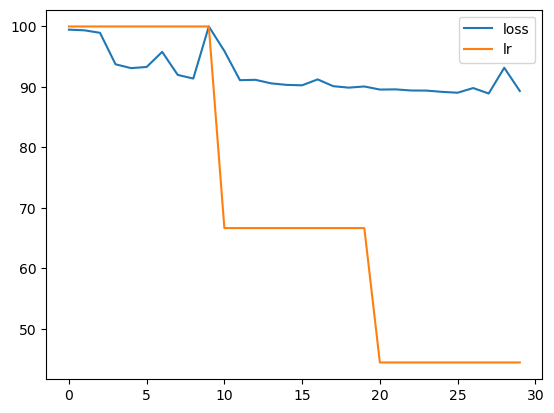

<Figure size 640x480 with 0 Axes>

In [81]:

usage_size = 130000
out_fast = train(source_fast_model, target_fast_model, n_epoch = 30, batch_size = batch_size, usage_size = usage_size, lr = 0.001, neural = RNN)
torch.save(out_fast[2].state_dict(), sys.path[0] + "/models/" + "fast_trained_model.pt") 
show (out_fast, usage_size = usage_size)

In [ ]:
#same thing with the glove model

usage_size = 130000
out_glove = train(source_glove_model, target_glove_model, n_epoch = 1, batch_size = batch_size, usage_size = usage_size, lr = 0.001, neural = RNN)
torch.save(out_glove[2].state_dict(), sys.path[0] + "/models/" + "glove_trained_model.pt")
show (out_glove, usage_size = usage_size)

In [ ]:
#same thing with the word2vec model
 
usage_size = 130000
out_word2vec = train(source_w2v_model_cbow, target_w2v_model_cbow, n_epoch = 1, batch_size = batch_size, usage_size = usage_size, lr = 0.001, neural = RNN)
torch.save(out_word2vec[2].state_dict(), sys.path[0] + "/models/" + "word2vec_trained_model.pt")
show (out_word2vec, usage_size = usage_size)

In [ ]:
#The following is for contextualized embeddings
raise (Exception("Stop cell"))

To this model we can now try to add contextual embeddings

In [ ]:
#for contextual embedding we will use BERT


import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

#we use bert and we will train it on the data
bert_model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
#we will make a function to get the embeddings of the sentences
def get_embeddings(sentences, src = True) :
    sentences_in = [token_to_word(sent, src=src) for sent in sentences]
    
    
    #concatenate the sentences
    sentences_in = [" ".join(sent).replace("<pad>", "").replace("<eos>", "") for sent in sentences_in]
    

    #we tokenize the sentences
    tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences_in]
    #we get the ids of the tokens
    indexed_tokens = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    
    #make sure the sentences are of the same length
    max_len = 15
    for i in range(len(indexed_tokens)) :
        while len(indexed_tokens[i]) < max_len :
            indexed_tokens[i].append(0)
            
    #same for tokenized texts
    for i in range(len(tokenized_texts)) :
        while len(tokenized_texts[i]) < max_len :
            tokenized_texts[i].append("<pad>")
    
    #we get the attention masks
    segments_ids = [[1] * len(sentence) for sentence in tokenized_texts]
    #we get the tensors
    tokens_tensor = torch.tensor([[indexed_tokens]])
    segments_tensors = torch.tensor([[segments_ids]])
    
    #we get the embeddings
    with torch.no_grad():
        #no idea why it doesn't work : too many values to unpack (expected 2)
        encoded_layers, _ = bert_model(tokens_tensor, segments_tensors)
        
    #we get the last layer
    token_embeddings = torch.stack(encoded_layers, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)
    token_embeddings = token_embeddings.permute(1,0,2)
    
    #we get the word embeddings
    word_embeddings = []
    for token in token_embeddings :
        word_embeddings.append(token[-1])
    
    return word_embeddings

In [ ]:
#we can modify the model to use the contextual embeddings

class BertRNN_encode(nn.Module):
    def __init__(self, embedding_model_input, embedding_model_output, hidden_size=50):
        super(BertRNN_encode, self).__init__()

        self.hidden_size = hidden_size
        
        embedding = torch.tensor(embedding_model_input.vectors).to(device)
        self.embedding_in = (embedding / torch.norm(embedding, dim=1, keepdim=True)).to(device)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.embedding_dim_in = self.embedding_in.shape[1]
        self.lstm_in = nn.LSTM(self.embedding_dim_in, self.embedding_dim_in, bidirectional=True, num_layers=2, dropout=0.01)
        self.hidden_in = nn.Linear(self.embedding_dim_in, self.hidden_size)
        self.hidden_in2 = nn.Linear(self.hidden_size, self.hidden_size)


    def forward(self, input_sentence):
        #words_embeddings is a gensim model
        input_sentence = torch.where((input_sentence < self.embedding_in.shape[0]).to(device), input_sentence.to(device), torch.zeros_like(input_sentence).to(device))
        one_hot = F.one_hot(input_sentence.type(torch.int64), self.embedding_in.shape[0]).to(device)
        embeds = torch.matmul(one_hot.type(torch.float), self.embedding_in.type(torch.float))
         
        #we get the bert embeddings
        bert_embed = get_embeddings(input_sentence, src=True)
        print("bert embed : ", bert_embed)
        
        embeds = torch.cat((embeds, bert_embed), dim=1)
        print(embeds.shape)
        
        #encoder
        output_lstm_1, _ = self.lstm_in(embeds.view(input_sentence.shape[0], input_sentence.shape[1], self.embedding_dim_in))
        
        #sum the two directions
        output_lstm_1 = output_lstm_1[:, :, :self.embedding_dim_in] + output_lstm_1[:, : ,self.embedding_dim_in:] + embeds
        soft = F.log_softmax(output_lstm_1, dim=2)
        
        output_hidden_1 = self.hidden_in(soft.view(input_sentence.shape[0], input_sentence.shape[1], self.embedding_dim_in))
        output_hidden_2 = self.hidden_in2(F.relu(output_hidden_1.view(input_sentence.shape[0], input_sentence.shape[1], self.hidden_size)))
        
        return F.log_softmax(output_hidden_2, dim=2)
    
class BertRNN(nn.Module) :
    def __init__(self, embedding_model_input, embedding_model_output, hidden_size=50):
        super(BertRNN, self).__init__()

        self.encoder = BertRNN_encode(embedding_model_input, embedding_model_output, hidden_size)
        self.decoder = RNN_decode(embedding_model_output, embedding_model_output, hidden_size)
    
    def forward(self, input_sentence) :
        output_hidden_1 = self.encoder(input_sentence)
        output_hidden_2 = self.decoder(output_hidden_1)
        return output_hidden_2

In [ ]:
# now use the train function to train the model

usage_size = 130000
out_bert = train(source_fast_model, target_fast_model, n_epoch = 1, batch_size = batch_size, usage_size = usage_size, lr = 0.001, neural = BertRNN)
torch.save(out_bert[2].state_dict(), sys.path[0] + "/models/" + "word2vec_trained_model.pt")
show (out_bert, usage_size = usage_size)

In [ ]:
#Attention
raise (Exception("Stop cell"))
   

In [97]:
#incorporate the attention mechanism in the decoder
import math
class RNN_decode_attention(nn.Module):
    def __init__(self, embedding_model_input, embedding_model_output, hidden_size=100):
        super(RNN_decode_attention, self).__init__()

        self.hidden_size = hidden_size
        
        embedding = torch.tensor(embedding_model_output.vectors).to(device)
        self.embedding_out = (embedding / torch.norm(embedding, dim=1, keepdim=True)).to(device)

        self.embedding_dim_out = self.embedding_out.shape[1]
        self.lstm_out = nn.LSTM(self.hidden_size, self.hidden_size, bidirectional=True)
        self.hidden_out = nn.Linear(self.hidden_size, self.embedding_dim_out)
        self.hidden_out2 = nn.Linear(self.embedding_dim_out, self.embedding_dim_out)
        
        #attention
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)
        self.attn2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.v = nn.Linear(self.hidden_size, self.hidden_size, bias = False)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_hidden):
        #decoder
        output_lstm_1, _ = self.lstm_out(input_hidden.view(input_hidden.shape[0], input_hidden.shape[1], self.hidden_size))
        
        #sum the two directions
        output_lstm_1 = output_lstm_1[:, :, :self.hidden_size] + output_lstm_1[:, : ,self.hidden_size:] + input_hidden
        
        #attention
        query = self.attn(output_lstm_1)
        key = self.attn2(input_hidden)
        value = self.v(input_hidden)
        output_lstm_1, attention = self.attention(query, key, value, dropout=self.dropout)
        
        output_hidden_1 = self.hidden_out(output_lstm_1.view(input_hidden.shape[0], input_hidden.shape[1], self.hidden_size))
        output_hidden_2 = self.hidden_out2(F.relu(output_hidden_1.view(input_hidden.shape[0], input_hidden.shape[1], self.embedding_dim_out)))
        
        #similarity
        out = torch.abs(output_hidden_2 @ self.embedding_out.transpose(0,1))
        return  F.log_softmax(out, dim=2) #size batch, sentence, size_voc
    
    def attention(self, query, key, value, dropout=None):
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        p_attn = F.softmax(scores, dim = -1)
        if dropout is not None:
            p_attn = dropout(p_attn)
        return torch.matmul(p_attn, value), p_attn
    
    def get_embedding(self):
        return self.embedding_out

In [98]:
class RNN_attention(nn.Module) :
    def __init__(self, embedding_model_input, embedding_model_output, hidden_size=100):
        super(RNN_attention, self).__init__()

        self.encoder = RNN_encode(embedding_model_input, embedding_model_output, hidden_size)
        self.decoder = RNN_decode_attention(embedding_model_output, embedding_model_output, hidden_size)
    
    def forward(self, input_sentence) :
        output_hidden_1 = self.encoder(input_sentence)
        output_hidden_2 = self.decoder(output_hidden_1)
        return output_hidden_2
    
    def get_embedding(self) :
        return self.decoder.get_embedding()

Ready
Epoch: 0/200............. Loss: 18101.279296875.............e : 0.21316683738460224 grad : 1.6037911336752586e-055
Epoch: 1/200............. Loss: 16593.744140625.............me : 0.22611064738336437 grad : 0.00618642568588256865
Epoch: 2/200............. Loss: 16460.751953125.............e : 0.23099506200310593 grad : 1.2924050679430366e-054
Epoch: 3/200............. Loss: 16307.9560546875.............me : 0.22773816416230597 grad : 0.0049037574790418155
Epoch: 4/200............. Loss: 16163.98046875.............time : 0.24189592110287736 grad : 0.0011069481261074543
Epoch: 5/200............. Loss: 15994.4609375............. time : 0.22308035716858096 grad : 0.0003675624029710889
Epoch: 6/200............. Loss: 16023.58203125.............time : 0.23445465056404188 grad : 0.00366178131662309173
Epoch: 7/200............. Loss: 15899.767578125.............me : 0.2652188412330388 grad : 0.000633115123491734305
Epoch: 8/200............. Loss: 15830.7880859375............. : 0.2718299

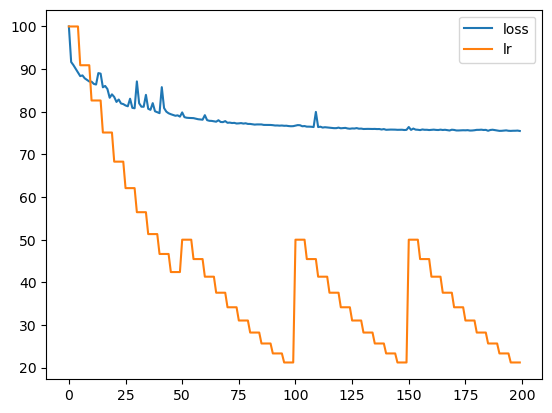

<Figure size 640x480 with 0 Axes>

In [85]:
#train it

usage_size = 130000
out_attention = train(source_fast_model, target_fast_model, n_epoch = 200, batch_size = batch_size, usage_size = usage_size, lr = 0.001, neural = RNN_attention)
torch.save(out_attention[2].state_dict(), sys.path[0] + "/models/" + "word2vec_trained_model.pt")
show (out_attention, usage_size = usage_size)


In [ ]:
#tests on the validation set
raise (Exception("Stop cell"))

In [95]:
test(out_attention[2].to(device), usage_size = usage_size, valid=2)

15
Original sentence : 
i am looking forward to your letter . <eos> <pad> <pad> <pad> <pad> <pad> <pad> 
3204 227 3790 2644 6542 7232 3691 7 20 21 21 21 21 21 21 
Translated sentence : 
<bos> je - ai ' . . . . <eos> <eos> <eos> <eos> <eos> <eos>
Target sentence : 
<bos> j ' attends <unk> ta lettre . <eos> <pad> <pad> <pad> <pad> <pad> <pad> 
20 5363 4 892 23 9716 5592 7 21 22 22 22 22 22 22 


In [ ]:
usage_size = 162000
batch_size = 256
data = MTFraEng(batch_size=batch_size)

In [102]:
out_attention = train(source_fast_model, target_fast_model, n_epoch = 200, batch_size = batch_size, usage_size = usage_size, lr = 0.001, neural = RNN_attention)
torch.save(out_attention[2].state_dict(), sys.path[0] + "/models/" + "word2vec_trained_model.pt")
show (out_attention, usage_size = usage_size)

Ready
Epoch: 0/200............. Loss: 19503.6953125.............time : 0.2250648839345461 grad : 2.4948989448603243e-056
Epoch: 1/200............. Loss: 18882.365234375.............me : 0.2214906264658393 grad : 0.002983324695378542427
Epoch: 2/200............. Loss: 17751.220703125.............me : 0.2237808671799615 grad : 0.000557243707589805157
Epoch: 3/200............. Loss: 17877.2578125............. time : 0.22289336809004906 grad : 0.0030283890664577484
Epoch: 4/200............. Loss: 17613.51171875.............e : 0.22848686148942798 grad : 0.0006337444065138698337
Epoch: 5/200............. Loss: 17435.224609375.............me : 0.22364969539119658 grad : 0.0064531848765909676
Epoch: 6/200............. Loss: 17473.341796875.............ime : 0.22468250726800024 grad : 6.191577995195985e-05
Epoch: 7/200............. Loss: 17386.24609375.............time : 0.22549617326561305 grad : 0.0006480496376752853
Epoch: 8/200............. Loss: 17405.7890625.............: 0.2249168932298

TypeError: test() got multiple values for argument 'usage_size'